<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<a href="./00_index.ipynb"><< Index </a><br>
<a href="./07_AC_SAF_GOME-2_L3_AAI_load_browse.ipynb"><< 07 - AC SAF GOME-2 Level 3 AAI - Load and browse </a>

<br>

<div class="alert alert-block alert-warning">
<b>LOAD, BROWSE AND VISUALIZE</b></div>

# AC SAF - GOME-2 - Data records (Level 3 products)

The [EUMETSAT Satellite Application Facility on Atmospheric Composition Monitoring (EUMETSAT AC SAF)](http://acsaf.org/) is one of eight EUMETSAT Satellite Application Facilities (SAFs). <br>

SAFs generate and disseminate operational EUMETSAT products and services and are an integral part of the distributed EUMETSAT Application Ground Segment. 

AC SAF processes data on ozone, other trace gases, aerosols and ultraviolet data, obtained from satellite instrumentation. AC SAF GOME-2 data records are monthly aggregated products (Level 3), regridded onto a regular latitude longitude grid. Data records are disseminated in the data format `netCDF`. 

Data records are processed for three parameters:

* `tropospheric ozone column`, 
* `total and tropospheric nitrogen dioxide column`, and 
* `total water vapour column`.

This notebook guides you through how the `Nitrogen Dioxide` data records can be loaded and gives basic plotting examples.

<br>

### Outline:
* [1 - Load and browse a single AC SAF GOME-2 data record](#load_l3)
* [2 - Open multiple NetCDF files at one](#open_mf_files)
* [3 - Plotting example of AC SAF GOME-2 Level 3 data](#plotting)

<hr>

#### Load required libraries

In [2]:
import os
from netCDF4 import Dataset
import xarray as xr
import numpy as np
import pandas as pd
import datetime

# Python libraries for visualisation
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

<hr>

### <a id="load_l3"></a>Load and browse AC SAF data records

#### Open one individual file with `xarray`

By using xarray's `open_dataset()` function, a `netCDF` file can be loaded to create a new xarray `Dataset`. You can have a look at the resulting `Dataset` and the `latitude` and `longitude` coordinates.

In [3]:
ds = xr.open_dataset('../eodata/gome2/level3/no2/GOME_NO2_Global_201710_METOPB_DLR_v1.nc')
ds, ds.latitude, ds.longitude

(<xarray.Dataset>
 Dimensions:    (latitude: 720, longitude: 1440)
 Coordinates:
   * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
   * longitude  (longitude) float32 -179.875 -179.625 ... 179.625 179.875
 Data variables:
     *empty*
 Attributes:
     description:  Level 3 NO2 data
     Conventions:  CF-1.6,
 <xarray.DataArray 'latitude' (latitude: 720)>
 array([-89.875, -89.625, -89.375, ...,  89.375,  89.625,  89.875],
       dtype=float32)
 Coordinates:
   * latitude  (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
 Attributes:
     standard_name:  latitude
     long_name:      latitude_Centre, center of the grid box
     units:          degrees_north,
 <xarray.DataArray 'longitude' (longitude: 1440)>
 array([-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
       dtype=float32)
 Coordinates:
   * longitude  (longitude) float32 -179.875 -179.625 ... 179.625 179.875
 Attributes:
     standard_name:  longitude
     long_name:  

<br>

You see that the `data variable` section is empty. This is due to the internal structure of the AC SAF GOME-2 Level 3 data. The data is organised in groups within the `netCDF` file. To load from a group, you have to pass the `group` keyword to the `open_dataset()` function. 

You can see that the `Dataset` contains six data variables:

* (1) `NO2total`, 
* (2) `NO2total_err`, 
* (3) `NO2total_stddev`, 
* (4) `NO2trop`,
* (5) `NO2trop_err`,
* (6) `NO2trop_stddev`

However, `latitude` and `longitude` do not contain any coordinates.

In [4]:
no2 = xr.open_dataset('../eodata/gome2/level3/no2/GOME_NO2_Global_201710_METOPB_DLR_v1.nc', group='PRODUCT', engine='netcdf4')
no2, no2.latitude, no2.longitude

(<xarray.Dataset>
 Dimensions:          (latitude: 720, longitude: 1440)
 Dimensions without coordinates: latitude, longitude
 Data variables:
     NO2total         (latitude, longitude) float32 ...
     NO2total_err     (latitude, longitude) float32 ...
     NO2total_stddev  (latitude, longitude) float32 ...
     NO2trop          (latitude, longitude) float32 ...
     NO2trop_err      (latitude, longitude) float32 ...
     NO2trop_stddev   (latitude, longitude) float32 ...
     nobs             (latitude, longitude) float32 ...,
 <xarray.DataArray 'latitude' (latitude: 720)>
 array([  0,   1,   2, ..., 717, 718, 719])
 Dimensions without coordinates: latitude,
 <xarray.DataArray 'longitude' (longitude: 1440)>
 array([   0,    1,    2, ..., 1437, 1438, 1439])
 Dimensions without coordinates: longitude)

<br>

You can use the xarray function `assign_coords` to assign the coordinate values from your dataset to the dimensions of your group dataset.

In [5]:
no2_assigned = no2.assign_coords(latitude=ds.latitude, longitude=ds.longitude)
no2_assigned.NO2trop

<xarray.DataArray 'NO2trop' (latitude: 720, longitude: 1440)>
[1036800 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
  * longitude  (longitude) float32 -179.875 -179.625 ... 179.625 179.875
Attributes:
    long_name:      Tropospheric Column NO2 content
    units:          molec cm-2
    standard_name:  troposphere_mole_content_of_nitrogen_dioxide

<br>

### <a id='open_mf_files'></a>Open multiple netCDF files with `xarray`

xarray's `open_mfdataset` function is very useful to load multiple netCDF files simultaneously. This function automatically concatenates and merges multiple files into a single xarray dataset. The behaviour of `open_mfdataset` is the same as the one of `open_dataset`. In order to access the dataset variables, you have to specify the `group` parameter. 

Additionally, if the dimension one want to concatenate the individual files is not defined in the original dataset, a new dimension can be defined by specifying the `concat_dim` key.

In [12]:
mf_dataset = xr.open_mfdataset('../eodata/gome2/level3/no2/*.nc', concat_dim='time', combine='nested',  group='PRODUCT')
mf_dataset

<xarray.Dataset>
Dimensions:          (latitude: 720, longitude: 1440, time: 130)
Dimensions without coordinates: latitude, longitude, time
Data variables:
    NO2total         (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_err     (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_stddev  (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop          (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_err      (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_stddev   (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs             (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

<br>

The resulting `Dataset` has three dimensions (`latitude`, `longitude` and `time`). With `assign_coords` you can assign the right coordinate values to the dimensions. You can use again the `ds` Dataset you defined at the beginning. 

With the help of Python's [pandas](https://pandas.pydata.org/) library, you can create efficiently a list of monthly time values, which can be assigned to the time dimension.

In [13]:
# Build list of time coordinates with pandas
time_coords = pd.date_range('2007-02', '2017-11', freq='MS').strftime("%Y-%m").tolist()

# Assign values to Dataset dimension
mf_dataset_assigned = mf_dataset.assign_coords(latitude=ds.latitude, longitude=ds.longitude, time=time_coords)
mf_dataset_assigned

<xarray.Dataset>
Dimensions:          (latitude: 720, longitude: 1440, time: 130)
Coordinates:
  * latitude         (latitude) float32 -89.875 -89.625 ... 89.625 89.875
  * longitude        (longitude) float32 -179.875 -179.625 ... 179.625 179.875
  * time             (time) <U7 '2007-02' '2007-03' ... '2017-10' '2017-11'
Data variables:
    NO2total         (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_err     (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_stddev  (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop          (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_err      (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_stddev   (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs             (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

<br>

### <a id="plotting"></a>Plotting example of AC SAF GOME-2 Level 3 data

#### Plot `Dataset NetCDF` library object with `matplotlib` and `cartopy`

The retrieved `data array` from the `Dataset NetCDF` object is of type `numpy.MaskedArray`, which can be plotted with matplotlib's `imshow` function. The plot extent can be set with minimum and maximum values of the `latitude` and `longitude` information respectively.

We create a function [visualize_imshow](./functions.ipynb#visualize_imshow), where we can specify `projection`, `extent`, `conversion_factor`, `color_scale`, `vmin`, `vmax`. We might want to re-use the function, thus we also add options to set a global extent and a logarithmic scaling of the colorbar.

In [14]:
def visualize_imshow(data_array, projection, extent, conversion_factor, color_scale, vmin, vmax, set_global=False, log_scale=False):
    """ 
    Visualizes a numpy MaskedArray with matplotlib's 'imshow' function.
    
    Parameters:
        data_array: any numpy MaskedArray, e.g. loaded with the NetCDF library and the Dataset function
        projection: a projection provided by the cartopy library, e.g. ccrs.PlateCarree()
        extent: list with the following order - [min(lon),max(lon),max(lat),min(lat)]
        conversion_factor(float): any number to convert the DataArray values
        color_scale(str): string taken from matplotlib's color ramp reference  
        vmin(int): minimum number on visualisation legend
        vmax(int): maximum number on visualisation legend
        set_global: set True, if the plot shall have a global coverage
        log_scale: set True, if the color_scale shall have a logarithmic scaling
    """
    fig=plt.figure(figsize=(20, 12))

    ax=plt.axes(projection=projection)
    ax.coastlines()
    ax.gridlines()
    if(set_global):
        ax.set_global()

    ax.set_title(data_array.long_name, fontsize=20, pad=20.0)

    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.top_labels=False
    gl.right_labels=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    
    gl.xlabel_style={'size':14}
    gl.ylabel_style={'size':14}
    
    if(log_scale):
        img1 = plt.imshow(data_array[:]*conversion_factor,
                          extent=extent,
                          cmap=color_scale,
                          aspect='auto',
                          norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))
    else:
        img1 = plt.imshow(data_array[:]*conversion_factor,
                          extent=extent,
                          cmap=color_scale,
                          vmin=vmin,
                          vmax=vmax,
                          aspect='auto')

    cbar = fig.colorbar(img1, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(str(conversion_factor) + ' ' + data_array.units, fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    
    plt.show()

<br>

#### Plot xarray `Dataset` object with `matplotlib` and `cartopy`

You can use the function [visualize_imshow](./ltpy_functions.ipynb#visualize_imshow) which you defined above, also to visualize a xarray `Dataset`. You select the parameter of interest, e.g. `NO2total` and define the extent based on the `DataArray's` minimum and maximum latitude / longitude information.
These information are then taken to plot the total column NO<sub>2</sub> content.

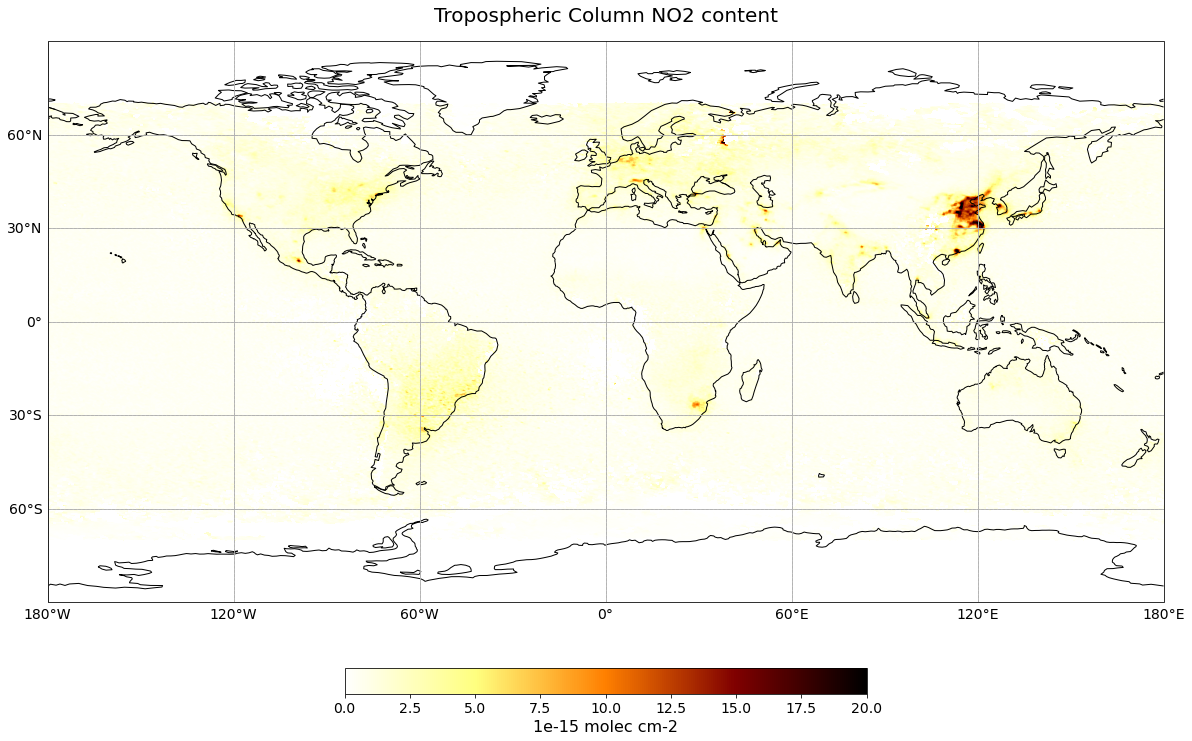

In [15]:
no2_da = no2_assigned.NO2trop

extent = [no2_da.longitude.min(),no2_da.longitude.max(),no2_da.latitude.max(),no2_da.latitude.min()]
visualize_imshow(no2_da, ccrs.PlateCarree(), extent, 1e-15, 'afmhot_r', 0, 20, set_global=True, log_scale=False)

<br>

<a href="./00_index.ipynb"><< Index </a><br>
<a href="./07_AC_SAF_GOME-2_L3_AAI_load_browse.ipynb"><< 07 - AC SAF GOME-2 Level 3 AAI - Load and browse </a>

<hr>

<img src='./img/copernicus_logo.png' alt='Logo EU Copernicus' align='right' width='20%'><br><br><br><br>

<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.